## Soft projekat

In [2]:
import cv2
import numpy as np
from scipy import ndimage
from vector import distance, pnt2line
from matplotlib.pyplot import cm 
import itertools
import time
from skimage.io import imread
from skimage.color import rgb2gray
from skimage import color
from skimage.measure import label
from skimage.measure import regionprops
from sklearn.datasets import fetch_mldata
from sklearn.neighbors import KNeighborsClassifier
import matplotlib.pyplot as plt  # za prikaz slika, grafika, itd.
%matplotlib inline

In [3]:
def gornjilevi(img):
    
    label_img = label(img)
    regions = regionprops(label_img)
    minx=800
    miny=800
    maxx=0
    maxy=0
    for region in regions:
        b_box = region.bbox
        if b_box[0]<minx:
            minx=bbox[0]
        if b_box[1] <miny:
            miny=bbox[1]
        if b_box[2]>maxx:
            maxx=bbox[2]
        if b_box[3]>maxy:
            maxy=bbox[3]

    height = maxx - minx
    width = maxy - miny
    slika = np.zeros((28, 28))

    slika[0:height, 0:width] = slika[0:height, 0:width] + img[minx:maxx, miny:maxy]
    return slika
    
    
def popuni(image):
    if(np.shape(image)!=(28,28)):
        img = np.zeros((28,28))
        x = 28 - np.shape(image)[0]
        y = 28 - np.shape(image)[1]
        img[:-x,:-y] = image
        return img
    else:
        return image
    


In [4]:
neighbours = KNeighborsClassifier(n_neighbors=1)
mnist = fetch_mldata('MNIST original')
data = mnist.data
datax = data.astype('uint8')
    
target = mnist.target
obradene = np.empty_like(datax)
    
for i in range(0,len(datax)):

    mnist_slika=datax[i].reshape(28,28)
    crnobelo=((color.rgb2gray(mnist_slika)/255.0)>0.88).astype('uint8')
    new_mnist_slika=gornjilevi(crnobelo)
    obradene[i]= new_mnist_slika.reshape(784,)
    
neighbours.fit(obradjene, target)

def KNNbroj(image):
    image_x = popuni(np.array(image.astype('uint8')))
    k = neighbours.predict(image_x.reshape(1,-1))
    return k

True


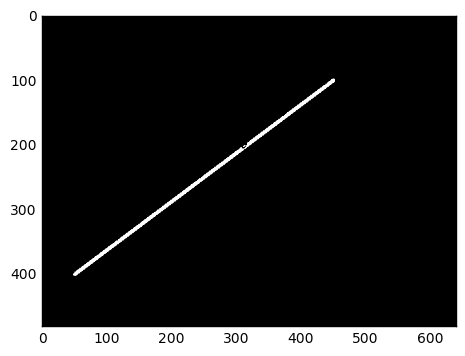

In [7]:
def koordinate(linije):
    
    minx=0
    miny=0
    maxy=0
    maxx=0
    for x1, y1, x2, y2 in linije[0]:
        minx=x1
        miny=y1
        maxx=x2
        maxy=y2
    for i in  range(len(linije)):
        for x1, y1, x2, y2 in linije[i]:
            if x1<minx :
                minx=x1
                miny=y1
            if x2>maxx:
                maxy=y2
                maxx=x2
                
    return minx,miny,maxx,maxy

def linija(granica, img):
    hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
    lower, upper = granica
    lower = np.array(lower, dtype = "uint8")
    upper = np.array(upper, dtype = "uint8")
    maska = cv2.inRange(hsv, lower, upper)
    rez = rgb2gray(cv2.bitwise_and(img, img, mask = maska))
    img_rez = rez >0.001  
    return img_rez

def hough_alg(img, granica):
    img_output = linija(granica, img)
    plt.imshow(img_output, 'gray') 
    from skimage import img_as_ubyte
    cv_image = img_as_ubyte(img_output)
    linija = cv2.HoughLinesP(cv_image,1,np.pi/180,100,600,10)
    x1, y1, x2, y2 = koordinate(linija)
    
    return x1, y1, x2, y2

video="video-0.avi"
    
def linijax(video):
    granica = [110, 100, 100], [130, 255, 255]
    cap = cv2.VideoCapture(video)
    print(cap.isOpened())
    ret, frame = cap.read()
    cap.release()
    cv2.destroyAllWindows()
    x11,y11,x12,y12=hough_alg(frame, granica)
    return x11,y11,x12,y12

x11,y11,x12,y12=linijax(video)

#LINIJA IZRACUNATA
linee = [(x11,y11),(x12,y12)]

def dodavanje_elementa(el, prosli):
    x = 0
    for elem in prosli:
        if (elem['id'] == el['id']):
            x = 1
    
    if x==0:
        prosli.append(el)
    
    return prosli

def najblizi(list,elem):

    temp = list[0]
    for obj in list:
        if distance(obj['center'],elem['center']) < distance(temp['center'],elem['center']):
            temp = obj
    
    return temp

In [10]:
cc = -1
def nextId():
    global cc
    cc += 1
    return cc

def inRange(r, item, items):
    retVal = []
    for obj in items:
        mdist = distance(item['center'], obj['center'])
        if(mdist<r):
            retVal.append(obj)
    return retVal

kernel = np.ones((2,2),np.uint8)
lower = np.array([230, 230, 230])
upper = np.array([255, 255, 255])

In [13]:
elementi = []
t =0
cap = cv2.VideoCapture(video)
ret, img3 = cap.read()
prosli = []

while(1):
    start_time = time.time()
    val, img = cap.read()
    if not val:
        break
    
    lower = np.array(lower, dtype = "uint8")
    upper = np.array(upper, dtype = "uint8")
    mask = cv2.inRange(img, lower, upper)    
    img0 = mask
    img1 = mask
    img0 = cv2.dilate(img0,kernel) 
    img0 = cv2.dilate(img0,kernel) 
    if(video=='video-0.avi'):
        img0 = cv2.dilate(img0,kernel)
        
    labeled, nr_objects = ndimage.label(img0)
    objects = ndimage.find_objects(labeled)
    
    for i in range(nr_objects):
        loc = objects[i]
        (xc,yc) = ((loc[1].stop + loc[1].start)/2, (loc[0].stop + loc[0].start)/2)
        (dxc,dyc) = ((loc[1].stop - loc[1].start), (loc[0].stop - loc[0].start))

        if(dxc>11 or dyc>11):
            
            cv2.rectangle(img, (xc-14,yc+14),(xc+14,yc-14), (25, 25, 255), 1)

            elem = {'center':(xc,yc), 't':t}
            
            # find in range
            lst = inRange(20, elem, elementi)
            nn = len(lst)
            if nn == 0:
                elem['id'] = nextId()
                elem['t'] = t
                elem['pass'] = False
                elem['pass2'] = False
                mnist_number = img1[yc-14:yc+14,xc-14:xc+14]
                elem['image'] = mnist_number
                elementi.append(elem)
                
            else:
                el = najblizi(lst,elem)
                el['center'] = elem['center']
                el['t'] = t
                el['image'] = img1[yc-14:yc+14,xc-14:xc+14]
                        
    for el in elementi:
        tt = t - el['t']
        if(tt<3):
            dist, pnt, r = pnt2line(el['center'], linee[0], linee[1])
            c = (0, 0, 255)
            if r>0:
                cv2.line(img, pnt, el['center'], (255, 0, 0), 1)
                if(dist<5):
                    if el['pass'] == False:
                        el['pass'] = True
                
                if(dist>5 & el['pass']==True):
                    c = (0, 255, 255)
                    prosli = dodavanje_elementa(el, prosli)
                    
            x = el['center'][0]
            y = el['center'][1]
            cv2.rectangle(img, (x-14,y+14),(x+14,y-14), c, 1)
            
            id = el['id']

    elapsed_time = time.time() - start_time
    
    t += 1
    cv2.imshow('frame', img)
    k = cv2.waitKey(30) & 0xff
    if k==27:
        break
    
    
cap.release()
cv2.destroyAllWindows()

   
s=0
i=0
print('Ukupno je proslo '+ str(len(prosli))+' elemenata')
for el in prosli:
    slika=gornjilevi(el['image'])
    i=i+1
    s= s + KNNbroj(slika)

print('Suma je jednaka %d ' %s)

Ukupno je proslo 7 elemenata
Suma je jednaka 35 
